# Importing necessary things

In [24]:
import pandas as pd
import numpy as np
import sklearn

import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import re
from datetime import datetime

import pickle

import string

==================================================================================================================

# EDA

In [2]:
# Retrieving the list.

import bz2

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [3]:
reviewlist = decompress_pickle('compressedlistreview.pbz2')
len(reviewlist)

6432

In [5]:
df = pd.DataFrame(reviewlist)
df

,content,score,thumbsUpCount,reviewCreatedVersion,appId
0,stamina system ruined it for me. any game that...,1,5,1.2.4,com.gravity.romNAg
1,An epic remake! I just wish it was less of a c...,4,5,1.2.4,com.gravity.romNAg
2,It crashes a lot. I've turned down all the set...,2,4,1.2.4,com.gravity.romNAg
3,I was a big fan when this came out mobile. I'v...,1,7,1.2.4,com.gravity.romNAg
4,It's a nice game at the moment of my first exp...,3,2,1.2.4,com.gravity.romNAg
...,...,...,...,...,...
6427,Good,5,0,1.2.2,com.gravity.romNAg
6428,Nice,5,0,None,com.gravity.romNAg
6429,good,4,0,None,com.gravity.romNAg
6430,i love it,1,0,None,com.gravity.romNAg


In [7]:
# checking for null values.

df.isna().sum()

content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    1175
appId                      0
dtype: int64

In [8]:
df['score'].value_counts()

5    3063
1    1765
4     639
3     560
2     405
Name: score, dtype: int64

In [11]:
count1 = len(df[df['score'] == 1])
count2 = len(df[df['score'] == 2])
count3 = len(df[df['score'] == 3])
count4 = len(df[df['score'] == 4])
count5 = len(df[df['score'] == 5])

total = count1 + count2 + count3 + count4 + count5

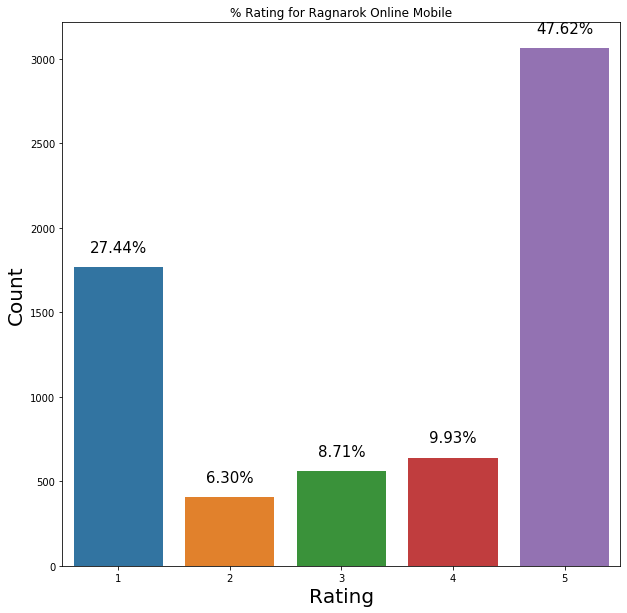

In [14]:
# Plotting distribution of ratings out of all the reviews
# Interestingly, it is very similar to overall rating distribution across all top mobile games.

plt.figure(figsize=(10,10))

xaxis = ['1', '2', '3', '4', '5']
yaxis = [count1, count2, count3, count4, count5]
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/total)+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [9]:
df['thumbsUpCount'].value_counts()

0      4656
1       906
2       307
3       130
4        86
       ... 
101       1
97        1
89        1
65        1
145       1
Name: thumbsUpCount, Length: 70, dtype: int64

In [10]:
df['reviewCreatedVersion'].value_counts()

1.0.1    4442
1.0.7     218
1.1.3     149
1.0.5     147
1.1.0     133
1.2.0      75
1.2.2      60
1.2.4      33
Name: reviewCreatedVersion, dtype: int64

==================================================================================================================

In [15]:
# Separating reviews into their scores.

rating1 = df.loc[df['score'] == 1]
rating2 = df.loc[df['score'] == 2]
rating3 = df.loc[df['score'] == 3]
rating4 = df.loc[df['score'] == 4]
rating5 = df.loc[df['score'] == 5]

In [25]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']
# Remove random numerals
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Remove contractions
stopwords_list += ["'d", "'ve", "ca", "n't",  "'t", "'re", "'ll", "'s"]

In [26]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed   

In [27]:
starttime = datetime.now()

rating1['wordlist'] = rating1['content'].apply(lambda x: process_reviews(x))
rating2['wordlist'] = rating2['content'].apply(lambda x: process_reviews(x))
rating3['wordlist'] = rating3['content'].apply(lambda x: process_reviews(x))
rating4['wordlist'] = rating4['content'].apply(lambda x: process_reviews(x))
rating5['wordlist'] = rating5['content'].apply(lambda x: process_reviews(x))

print(datetime.now() - starttime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0:00:01.730808


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [28]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [29]:
starttime = datetime.now()

rating1['wordlistlem'] = rating1['wordlist'].apply(lemmatize_text)
rating2['wordlistlem'] = rating2['wordlist'].apply(lemmatize_text)
rating3['wordlistlem'] = rating3['wordlist'].apply(lemmatize_text)
rating4['wordlistlem'] = rating4['wordlist'].apply(lemmatize_text)
rating5['wordlistlem'] = rating5['wordlist'].apply(lemmatize_text)

print(datetime.now() - starttime)

0:00:01.741035


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [31]:
starttime = datetime.now()

processedreviewrating1 = [item for elem in rating1['wordlistlem'] for item in elem]
processedreviewrating2 = [item for elem in rating2['wordlistlem'] for item in elem]
processedreviewrating3 = [item for elem in rating3['wordlistlem'] for item in elem]
processedreviewrating4 = [item for elem in rating4['wordlistlem'] for item in elem]
processedreviewrating5 = [item for elem in rating5['wordlistlem'] for item in elem]

print(datetime.now() - starttime)
print('------------')
print(len(processedreviewrating1))
print(len(processedreviewrating2))
print(len(processedreviewrating3))
print(len(processedreviewrating4))
print(len(processedreviewrating5))

0:00:00.008963
------------
31875
8383
10817
9368
24793


In [32]:
totalprocessedreviews = processedreviewrating1 + processedreviewrating2 + processedreviewrating3 + processedreviewrating4 + processedreviewrating5
len(totalprocessedreviews)

85236

In [33]:
review_freqdist = FreqDist(totalprocessedreviews)
review_freqdist.most_common(20)

[('game', 4826),
 ('play', 1150),
 ('time', 832),
 ('get', 766),
 ('good', 760),
 ('love', 697),
 ('great', 696),
 ('like', 669),
 ('fun', 624),
 ('screen', 604),
 ('even', 510),
 ('issue', 437),
 ('fix', 423),
 ('would', 423),
 ('day', 417),
 ('really', 412),
 ('ragnarok', 412),
 ('mobile', 406),
 ('playing', 406),
 ('still', 388)]

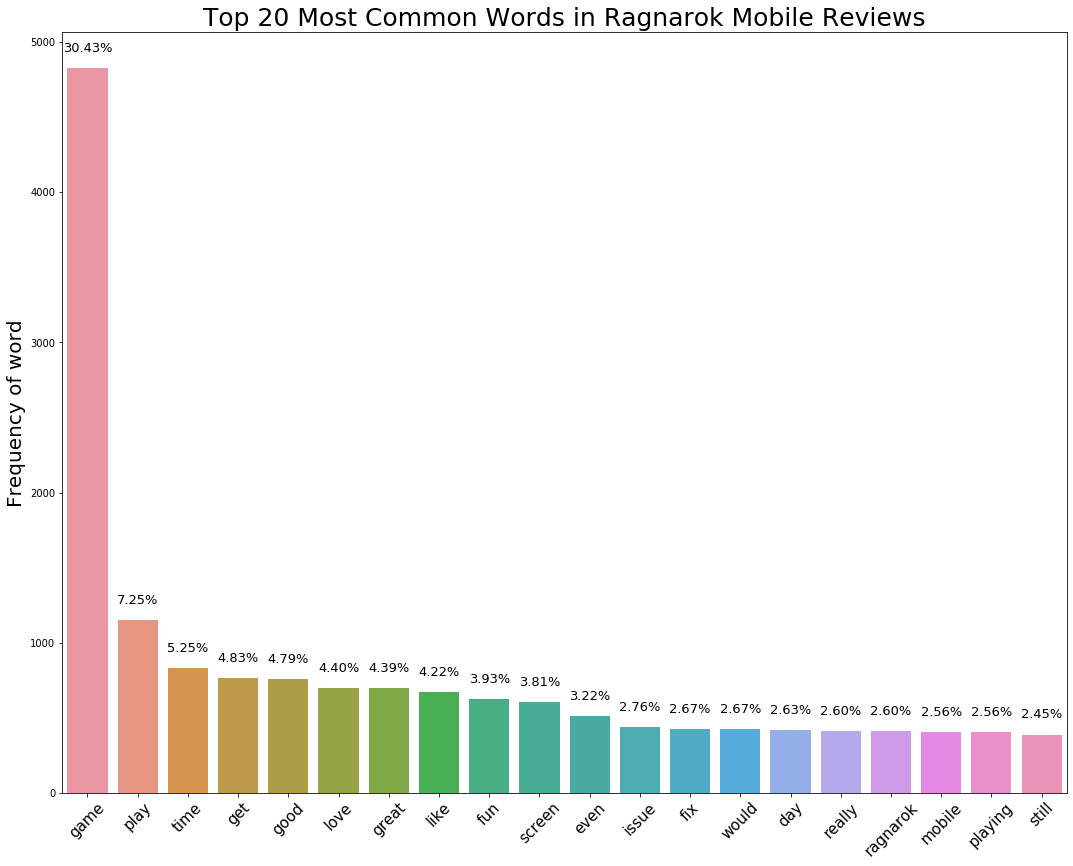

In [34]:
mostcommonwords20 = review_freqdist.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20]

xaxis20 = [val[0] for val in mostcommonwords20]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Top 20 words per Rating [Lemmatized]

In [37]:
uselesswords = ['game', 'play', 'get', 'still', 'would']
processedreviewrating1[:] = [x for x in processedreviewrating1 if x not in uselesswords]

In [38]:
review1_freqdist = FreqDist(processedreviewrating1)
review1_freqdist.most_common(20)

[('even', 340),
 ('time', 333),
 ('screen', 272),
 ('fix', 196),
 ('money', 185),
 ('player', 176),
 ('start', 175),
 ('app', 168),
 ('issue', 165),
 ('day', 164),
 ('download', 159),
 ('phone', 156),
 ('account', 151),
 ('cant', 148),
 ('like', 144),
 ('update', 144),
 ('keep', 137),
 ('open', 137),
 ('log', 132),
 ('support', 126)]

In [39]:
processedreviewrating2[:] = [x for x in processedreviewrating2 if x not in uselesswords]

In [40]:
review2_freqdist = FreqDist(processedreviewrating2)
review2_freqdist.most_common(20)

[('screen', 93),
 ('time', 90),
 ('issue', 64),
 ('fix', 59),
 ('start', 53),
 ('reinstall', 53),
 ('like', 52),
 ('day', 51),
 ('log', 50),
 ('every', 47),
 ('even', 46),
 ('really', 45),
 ('good', 44),
 ('playing', 43),
 ('work', 43),
 ('phone', 43),
 ('star', 42),
 ('login', 42),
 ('update', 40),
 ('make', 39)]

In [41]:
processedreviewrating3[:] = [x for x in processedreviewrating3 if x not in uselesswords]

In [42]:
review3_freqdist = FreqDist(processedreviewrating3)
review3_freqdist.most_common(20)

[('time', 124),
 ('screen', 111),
 ('like', 98),
 ('good', 86),
 ('star', 82),
 ('fix', 81),
 ('issue', 74),
 ('start', 73),
 ('every', 70),
 ('great', 65),
 ('reinstall', 64),
 ('playing', 63),
 ('day', 62),
 ('fun', 62),
 ("'m", 60),
 ('really', 59),
 ('need', 57),
 ('log', 56),
 ('login', 55),
 ('even', 52)]

In [43]:
processedreviewrating4[:] = [x for x in processedreviewrating4 if x not in uselesswords]

In [44]:
review4_freqdist = FreqDist(processedreviewrating4)
review4_freqdist.most_common(20)

[('good', 133),
 ('great', 113),
 ('fun', 97),
 ('like', 87),
 ('time', 85),
 ('love', 76),
 ('screen', 68),
 ('issue', 67),
 ('really', 55),
 ('star', 55),
 ('ragnarok', 54),
 ('mobile', 54),
 ('ro', 54),
 ('far', 52),
 ('playing', 49),
 ('pretty', 49),
 ('lot', 48),
 ('fix', 45),
 ('original', 45),
 ('one', 43)]

In [45]:
processedreviewrating5[:] = [x for x in processedreviewrating5 if x not in uselesswords]

In [46]:
review5_freqdist = FreqDist(processedreviewrating5)
review5_freqdist.most_common(20)

[('love', 471),
 ('great', 417),
 ('good', 410),
 ('fun', 368),
 ('like', 288),
 ('mobile', 258),
 ('ragnarok', 238),
 ('ro', 236),
 ('back', 216),
 ('best', 208),
 ('time', 200),
 ('original', 184),
 ('old', 170),
 ('really', 166),
 ('amazing', 164),
 ('far', 161),
 ('awesome', 158),
 ('played', 150),
 ('nice', 144),
 ('pc', 143)]

# Bigrams/Trigrams

In [47]:
def n_gramall(df_col, n=None):
    # Build the vectorizer, specify inputted n-gram, remove stop words
    vect = CountVectorizer(ngram_range = (n,n), stop_words = gramstopwords_list, min_df = 10)
    # fit/transform vectorizer on specified column
    vect_fit = vect.fit_transform(df_col.values.astype('U'))
    # get all words and store in a list
    word_list = vect.get_feature_names()
    # get a count of all the words
    count_list = vect_fit.toarray().sum(axis=0)
    #create a dictionary of word to count pairings
    count_dict = dict(zip(word_list, count_list))
    # sort the dictionary to show highest counted words on top
    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab

In [48]:
gramstopwords_list = stopwords.words('english') + list(string.punctuation)
gramstopwords_list += ["''", '""', '...', '``']

In [50]:
bigramall = n_gramall(df['content'], n=2)
bigramall[:20]

[('great game', 285),
 ('love game', 211),
 ('play game', 182),
 ('good game', 176),
 ('please fix', 128),
 ('fun game', 115),
 ('pay win', 111),
 ('brings back', 109),
 ('ragnarok online', 97),
 ('uninstall reinstall', 85),
 ('reinstall game', 84),
 ('game play', 76),
 ('start game', 76),
 ('touch start', 74),
 ('playing game', 73),
 ('start screen', 73),
 ('every time', 71),
 ('mobile game', 70),
 ('game great', 68),
 ('login screen', 67)]

In [51]:
trigramall = n_gramall(df['content'], n=3)
trigramall[:20]

[('best game ever', 36),
 ('brings back memories', 32),
 ('uninstall reinstall game', 28),
 ('touch start game', 27),
 ('game brings back', 25),
 ('stuck loading screen', 23),
 ('using google account', 23),
 ('stuck login screen', 22),
 ('original ragnarok online', 20),
 ('touch start screen', 20),
 ('cant even play', 16),
 ('cant get past', 16),
 ('brings back many', 15),
 ('past touch start', 15),
 ('screen please fix', 14),
 ('brings back old', 13),
 ('stuck title screen', 13),
 ('tried clearing cache', 13),
 ('able play game', 12),
 ('even play game', 12)]

# Bigrams/Trigrams for Ratings

In [54]:
# Rating 1

bigram1 = n_gramall(rating1['content'], n=2)
bigram1[:20]

[('play game', 104),
 ('pay win', 63),
 ('please fix', 59),
 ('cant even', 42),
 ('black screen', 39),
 ('start game', 39),
 ('even play', 35),
 ('loading screen', 35),
 ('reinstall game', 33),
 ('download game', 32),
 ('google account', 32),
 ('uninstall reinstall', 32),
 ('every time', 31),
 ('great game', 30),
 ('start screen', 29),
 ('playing game', 28),
 ('get past', 27),
 ('get game', 26),
 ('open game', 26),
 ('waste time', 26)]

In [55]:
trigram1 = n_gramall(rating1['content'], n=3)
trigram1[:20]

[('using google account', 14),
 ('cant even play', 13),
 ('stuck loading screen', 12),
 ('touch start game', 10)]

In [56]:
# Rating 2

bigram2 = n_gramall(rating2['content'], n=2)
bigram2[:20]

[('play game', 23),
 ('please fix', 19),
 ('reinstall game', 19),
 ('every time', 16),
 ('good game', 15),
 ('love game', 15),
 ('uninstall reinstall', 15),
 ('login screen', 13),
 ('great game', 12),
 ('like game', 12),
 ('fun game', 11),
 ('able play', 10),
 ('start game', 10),
 ('touch start', 10)]

In [64]:
# Returns nothing.

#trigram2 = n_gramall(rating2['content'], n=3)
#trigram2[:20]

In [58]:
# Rating 3

bigram3 = n_gramall(rating3['content'], n=2)
bigram3[:20]

[('love game', 30),
 ('good game', 28),
 ('great game', 25),
 ('please fix', 23),
 ('uninstall reinstall', 21),
 ('touch start', 20),
 ('reinstall game', 19),
 ('start game', 18),
 ('every days', 16),
 ('fun game', 16),
 ('like game', 16),
 ('login screen', 16),
 ('play game', 15),
 ('every time', 14),
 ('start screen', 14),
 ('game great', 13),
 ('give stars', 13),
 ('game good', 12),
 ('game would', 12),
 ('gets stuck', 12)]

In [ ]:
# Returns nothing.

#trigram3 = n_gramall(rating3['content'], n=3)
#trigram3[:20]

In [59]:
# Rating 4

bigram4 = n_gramall(rating4['content'], n=2)
bigram4[:20]

[('great game', 51),
 ('good game', 38),
 ('love game', 26),
 ('fun game', 24),
 ('ragnarok online', 23),
 ('please fix', 18),
 ('pretty good', 16),
 ('play game', 13),
 ('start screen', 13),
 ('game play', 12),
 ('pretty fun', 12),
 ('game great', 11),
 ('get past', 11),
 ('touch start', 11)]

In [65]:
# Returns nothing.

#trigram4 = n_gramall(rating4['content'], n=3)
#trigram4[:20]

In [66]:
# Rating 5

bigram5 = n_gramall(rating5['content'], n=2)
bigram5[:20]

[('great game', 167),
 ('love game', 118),
 ('brings back', 87),
 ('good game', 78),
 ('ragnarok online', 60),
 ('best game', 59),
 ('fun game', 57),
 ('amazing game', 50),
 ('awesome game', 50),
 ('mobile game', 48),
 ('game ever', 41),
 ('nice game', 41),
 ('original ro', 33),
 ('pc version', 33),
 ('back memories', 32),
 ('game play', 31),
 ('years ago', 30),
 ('game love', 29),
 ('original ragnarok', 29),
 ('really fun', 29)]

In [63]:
trigram5 = n_gramall(rating5['content'], n=3)
trigram5[:20]

[('best game ever', 33),
 ('brings back memories', 27),
 ('game brings back', 19),
 ('brings back many', 11),
 ('brings back old', 10),
 ('original ragnarok online', 10)]